In [14]:
import gym
from gym import Env, spaces

import numpy as np
import seaborn as sns
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import random
import networkx as nx
import matplotlib.patches as mpatches

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

import gymnasium as gym
from gymnasium import Env, spaces

from sklearn import preprocessing


Configurar o Enxame


In [15]:
num_drones = 3
limite_y = 80
limite_x = 100
alcance_comunicacao_jammer = 25
alcance_comunicacao_nos = 5000
B_Hz = 2.4e9
posicoes = np.array([[18, 52], [33, 20], [44, 15]])
posicao_jammer = np.array([38, 50])

VIZUALIZAÇÃO DAS DIREÇÕES DAS ANTENAS ESCOLHIDAS ALEATORIAMENTE

In [16]:
# Função para calcular a distância entre duas posições
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# Função para encontrar vizinhos dentro do alcance de comunicação
def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

# Função para verificar quais drones são afetados pelo jammer
def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer

# Gera direções aleatórias para as antenas
direcoes_antena = np.random.uniform(0, 360, size=num_drones)
# direcoes_antena = [278, 102, 235, 312, 182, 242]
afetados_pelo_jammer=verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)
# Comprimento das setas para indicar a direção das antenas
comprimento_seta = 5

# Criar a figura
fig = go.Figure()

# Adiciona os drones
for i in range(num_drones):
    cor = 'blue' if i in afetados_pelo_jammer else 'blue' # type: ignore
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0]],
        y=[posicoes[i, 1]],
        mode='markers+text',
        marker=dict(size=10, color=cor),
        text=str(i),
        textposition="bottom center",
        showlegend=False
    ))

    # Calcular as coordenadas da seta para a direção da antena
    direcao_radianos = np.radians(direcoes_antena[i])
    dx = comprimento_seta * np.cos(direcao_radianos)
    dy = comprimento_seta * np.sin(direcao_radianos)
    seta_x = posicoes[i, 0] + dx
    seta_y = posicoes[i, 1] + dy
    
    # Adiciona uma linha para indicar a direção da antena
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0], seta_x],
        y=[posicoes[i, 1], seta_y],
        mode='lines',
        line=dict(color='black', width=1.5),
        showlegend=False
    ))

# Adiciona o jammer
fig.add_trace(go.Scatter(
    x=[posicao_jammer[0]],
    y=[posicao_jammer[1]],
    mode='markers',
    marker=dict(size=12, color='red'),
    name='Jammer'
))

# Adiciona rastros para a legenda
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='blue'), name="Drone"))
# fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='orange'), name="Nó afetado"))

# Configurações do gráfico
fig.update_layout(
    title="Simulação de Modelo de Comunicação Wireless entre Drones",
    xaxis=dict(range=[0, limite_x], autorange=False),
    yaxis=dict(range=[0, limite_y], autorange=False),
    legend_title_text='Legenda',
    legend=dict(traceorder='normal', itemsizing='constant')
)

fig.show()
print(direcoes_antena)

c:\Users\tass\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



[323.54670496 110.15750534  80.4988873 ]


CALCULO DE TODOS OS ANGULOS A USAR

In [17]:
import numpy as np

# Função para calcular o ângulo entre dois nós em relação à direção da antena
def angulo_entre_nos(pos1, direcao_antena, pos2):
    # Vetor entre os dois nós
    delta_x = pos2[0] - pos1[0]
    delta_y = pos2[1] - pos1[1]
    
    # Direção do vetor em graus
    direcao_vetor_rad = np.arctan2(delta_y, delta_x)
    direcao_vetor_deg = np.degrees(direcao_vetor_rad)
    
    # Diferença entre a direção do vetor e a direção da antena
    angulo = direcao_vetor_deg - direcao_antena
    
    # Ajustar para o intervalo de 0 a 360 graus
    angulo = angulo % 360  # Usa módulo para garantir que o valor esteja entre 0 e 360
    angulo_arredondado = round(angulo)
    
    return angulo_arredondado

# Posições dos drones
# posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50]])

# Direções aleatórias das antenas
# direcoes_antena = np.random.uniform(0, 360, size=posicoes.shape[0])

# Matriz para armazenar os ângulos
angulos_matriz = np.zeros((posicoes.shape[0], posicoes.shape[0]))

# Calcular os ângulos para todas as combinações de drones
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            angulos_matriz[i, j] = angulo_entre_nos(posicoes[i], direcoes_antena[i], posicoes[j])

# Apresentar os ângulos entre drones sem valores negativos
for i in range(posicoes.shape[0]):
    print(f"Drones que o drone {i} 'vê' com um ângulo:")
    for j in range(posicoes.shape[0]):
        if i != j:
            angulo_arredondado = int(round(angulos_matriz[i, j]))  # Arredondar para unidade
            print(f"  Com o drone {j}: {angulo_arredondado} graus")

Drones que o drone 0 'vê' com um ângulo:
  Com o drone 1: 332 graus
  Com o drone 2: 342 graus
Drones que o drone 1 'vê' com um ângulo:
  Com o drone 0: 5 graus
  Com o drone 2: 225 graus
Drones que o drone 2 'vê' com um ângulo:
  Com o drone 0: 45 graus
  Com o drone 1: 75 graus


PARAMETROS 


In [18]:
Ptx_dBm = 20 
f = 2.4e9 
B_Hz= 2.4e9
d0=1
gamma=2
sigma = 0
c=3e8
lambda_m=c/f
L0=30
potencia_jammer_dBm =100

# Ler o arquivo de ganhos para criar uma tabela de busca
ganhos_df = pd.read_csv('ganhos.csv')

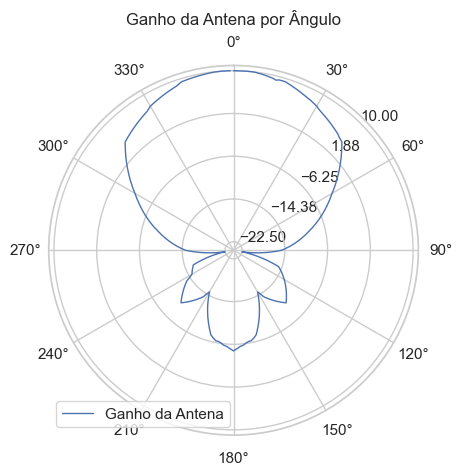

In [19]:
angulos = np.deg2rad(ganhos_df['angulo'])  # Converter graus para radianos
ganhos = ganhos_df['ganho']

# Criar um gráfico polar
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angulos, ganhos, linestyle='-', linewidth=1, label='Ganho da Antena')

# Ajustar o layout
ax.set_theta_zero_location('N')  # Configurar a direção Norte como o topo do gráfico
ax.set_theta_direction(-1)  # Configurar a direção dos ângulos para sentido horário
ax.set_rmax(max(ganhos) + 1)  # Ajustar o raio máximo para melhor visualização
ax.set_rticks(np.linspace(min(ganhos), max(ganhos), num=5))  # Definir os ticks para o raio
ax.set_rlabel_position(45)  # Posicionar os labels do raio

# Configurar os ticks para o ângulo
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Definir marcas de ângulo a cada 30 graus

# Adicionar legenda e título
ax.legend()
ax.set_title('Ganho da Antena por Ângulo', va='bottom')

# Mostrar o gráfico
plt.show()

In [20]:
def busca_ganhos( angulo):
    # Arredondar para o ângulo inteiro mais próximo
    angulo_ajustado = int(round(angulo))
    
    if angulo_ajustado==360:
        angulo_ajustado=0
    
    # Encontrar o ganho correspondente ao ângulo ajustado
    ganho = ganhos_df.loc[ganhos_df['angulo'] == angulo_ajustado, 'ganho'].iloc[0]
    
    return ganho



# Função para calcular os ganhos de transmissão e recepção
def calcula_ganhos(posicoes, direcoes_antena, indice_transmissor, indice_receptor, ganhos_df):
    # Obter posições e direções
    pos1 = posicoes[indice_transmissor]
    pos2 = posicoes[indice_receptor]
    direcao_antena1 = direcoes_antena[indice_transmissor]
    direcao_antena2 = direcoes_antena[indice_receptor]
    
    # Calcular o ângulo entre os dois nós em relação à direção da antena
    angulo_transmissao = angulo_entre_nos(pos1, direcao_antena1, pos2)
    angulo_rececao = angulo_entre_nos(pos2, direcao_antena2, pos1)
    # print('Angulo receção:',angulo_rececao)
    # print('Angulo tranmissão:',angulo_transmissao)

    # Obter os ganhos para transmissão e recepção
    ganho_transmissao = busca_ganhos( angulo_transmissao)
    ganho_rececao = busca_ganhos( angulo_rececao)
    
    return ganho_transmissao, ganho_rececao

# ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, 0, 1, ganhos_df)



def calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d,f):
    """
    Calcula a potência do sinal recebido usando a equação de Friis.
    """
    # L = (4 * np.pi * d / lambda_m)**2
    # Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - 10 * np.log10(L)
    # return Prx_dBm
    # Calcular a perda de percurso
    if d > 0:
        L = L0 + 10 * gamma * np.log10(d / d0) + np.random.normal(0, sigma)
    else:
        L = L0  # Se a distância for zero, assume-se a perda na distância de referência

    # Calcular a potência do sinal recebido
    Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - L

    return Prx_dBm

def calcula_potencia_jammer(pos_drone, direcao_antena_drone, pos_jammer, potencia_jammer_dBm, ganhos_df):
    # Calcular a distância entre o drone e o jammer
    d = distancia(pos_drone, pos_jammer)
    
    # Calcular o ângulo entre o drone e o jammer
    angulo_entre_drone_e_jammer = angulo_entre_nos(pos_drone, direcao_antena_drone, pos_jammer)
    
    # Obter o ganho do drone em direção ao jammer
    ganho_drone_para_jammer = busca_ganhos( angulo_entre_drone_e_jammer)
    
    # Calcular a potência do ruído recebido usando a equação de Friis
    L = (4 * np.pi * d / lambda_m) ** 2  # Perda de propagação
    potencia_jammer_recebida_dBm = potencia_jammer_dBm + ganho_drone_para_jammer - 10 * np.log10(L)
    
    return potencia_jammer_recebida_dBm

def calcula_capacidade(potencia_sinal_dBm, potencia_ruido_dBm):
    """
    Calcula a capacidade do canal em bits por segundo usando a fórmula de Shannon-Hartley.
    """
    # Converter potência em dBm para Watts
    potencia_sinal_W = 10 ** (potencia_sinal_dBm / 10) / 1000  # Potência do sinal em Watts
    potencia_ruido_W = 10 ** (potencia_ruido_dBm / 10) / 1000  # Potência do ruído em Watts
    
    # Calcular a razão sinal-ruído (SNR)
    snr = potencia_sinal_W / potencia_ruido_W
    
    # Calcular a capacidade do canal em bits por segundo (bps)
    capacidade = B_Hz * np.log2(1 + snr)
    
    return capacidade/1e3

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            # Calcular a distância entre os dois drones
            d = distancia(posicoes[i], posicoes[j])
            
            # Calcular os ganhos de transmissão e recepção
            ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, i, j, ganhos_df)
            # print(posicoes)
            print('Ganhos Rx,Tx:',ganho_transmissao, ganho_rececao)
            # Calcular a potência do sinal recebido usando a equação de Friis
            potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
            potencia_ruido = calcula_potencia_jammer(posicoes[j], direcoes_antena[j], posicao_jammer, potencia_jammer_dBm, ganhos_df)
            capacidade_canal=calcula_capacidade(potencia_recebida,potencia_ruido)
            # Imprimir a combinação de nós e a potência do sinal recebido
            print(f"  Potencia recebida do drone {i} para o drone {j}: {potencia_recebida:.2f} dBm")
            print(f"  Ruido recebido no drone {j} e do jammer: {potencia_ruido:.2f} dBm")
            print(f"  Capacidade do canal {i} para {j}: {capacidade_canal:.2f} bps")



Ganhos Rx,Tx: 7.76 10.0
  Potencia recebida do drone 0 para o drone 1: -23.21 dBm
  Ruido recebido no drone 1 e do jammer: 37.79 dBm
  Capacidade do canal 0 para 1: 2.75 bps
Ganhos Rx,Tx: 9.2 5.0
  Potencia recebida do drone 0 para o drone 2: -28.91 dBm
  Ruido recebido no drone 2 e do jammer: 38.05 dBm
  Capacidade do canal 0 para 2: 0.70 bps
Ganhos Rx,Tx: 10.0 7.76
  Potencia recebida do drone 1 para o drone 0: -23.21 dBm
  Ruido recebido no drone 0 e do jammer: 41.14 dBm
  Capacidade do canal 1 para 0: 1.27 bps
Ganhos Rx,Tx: -10.0 -9.0
  Potencia recebida do drone 1 para o drone 2: -50.64 dBm
  Ruido recebido no drone 2 e do jammer: 38.05 dBm
  Capacidade do canal 1 para 2: 0.00 bps
Ganhos Rx,Tx: 5.0 9.2
  Potencia recebida do drone 2 para o drone 0: -28.91 dBm
  Ruido recebido no drone 0 e do jammer: 41.14 dBm
  Capacidade do canal 2 para 0: 0.34 bps
Ganhos Rx,Tx: -9.0 -10.0
  Potencia recebida do drone 2 para o drone 1: -50.64 dBm
  Ruido recebido no drone 1 e do jammer: 37.79 dBm

CRIAR O ENVIRONMENT

In [21]:
seed=0

class UAVCommunicationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=num_drones, area_size=(100, 100)):
        super().__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.posicoes = posicoes
        self.posicao_jammer = posicao_jammer
        self.ultimo_info = {}

        # Define o espaço de ação como direções para cada drone
        self.action_space = spaces.MultiDiscrete([360] * num_uavs)
        self.observation_space = spaces.MultiDiscrete([360] * num_uavs)

        self.direcoes_antena = np.random.uniform(0, 360, size=num_uavs)
        self.capacidades = []  # Inicializa a lista de capacidades para normalização

    def step(self, action):
        self.direcoes_antena = np.array(action)
        capacidades_por_link = []
        
        for i in range(self.posicoes.shape[0]):
            for j in range(self.posicoes.shape[0]):
                if i != j:
                    d = distancia(self.posicoes[i], self.posicoes[j])
                    ganho_transmissao, ganho_rececao = calcula_ganhos(self.posicoes, self.direcoes_antena, i, j, ganhos_df)
                    potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
                    potencia_ruido = calcula_potencia_jammer(self.posicoes[j], self.direcoes_antena[j], self.posicao_jammer, potencia_jammer_dBm, ganhos_df)
                    capacidade_canal = calcula_capacidade(potencia_recebida, potencia_ruido)
                    capacidades_por_link.append(capacidade_canal)

        capacidade_media = np.mean(capacidades_por_link)
        capacidade_minima = np.min(capacidades_por_link)

        # Armazenar capacidades para normalização
        self.capacidades.extend(capacidades_por_link)
        

        # Normalização das capacidades
        min_capacidade = np.min(self.capacidades)
        max_capacidade = np.max(self.capacidades)
        capacidade_media_normalizada = (capacidade_media - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)
        capacidade_minima_normalizada = (capacidade_minima - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)

        # Com Normalização
        recompensa = 0.8 * capacidade_media_normalizada + 0.2 * capacidade_minima_normalizada
        
        # Sem Normalização
        # recompensa = 1.0 * capacidade_media + 0.0 * capacidade_minima

        capacidades_por_link = [round(capacidade, 3) for capacidade in capacidades_por_link]
        
        # print(capacidades_por_link)
        
        capacidade_media = round(capacidade_media, 3)
        
        capacidade_matriz = np.zeros((self.num_uavs, self.num_uavs))
        link_index = 0

        for i in range(self.num_uavs):
            for j in range(self.num_uavs):
                if i != j:
                    capacidade_matriz[i, j] = capacidades_por_link[link_index]
                    link_index += 1

        info = {
            'Recompensa': recompensa,
            'Capacidade média [Kbps]': capacidade_media,
            'Capacidades_por_link [Kbps]': capacidades_por_link,
            'Matriz de Capacidades [Kbps]': capacidade_matriz,
            'Capacidade mínima [Kbps]': capacidade_minima,
            'Capacidade média normalizada': capacidade_media_normalizada,
            'Capacidade mínima normalizada': capacidade_minima_normalizada
        }

        done = False
        return np.array(self.direcoes_antena), recompensa, done, info
    
    def render(self, mode='human'):
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(9, 4))

        # Desenha os drones no gráfico
        for i, pos in enumerate(self.posicoes):
            ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone' if i == 0 else "")
            ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

        # Desenha as setas para a direção das antenas
        comprimento_seta = 5  # Comprimento das setas
        for i, direcao in enumerate(self.direcoes_antena):
            direcao_rad = np.radians(direcao)  # Converte para radianos
            dx = comprimento_seta * np.cos(direcao_rad)  # Deslocamento em x
            dy = comprimento_seta * np.sin(direcao_rad)  # Deslocamento em y
            
            ax.arrow(
                self.posicoes[i][0], self.posicoes[i][1], 
                dx, dy, 
                head_width=2, head_length=2, fc='b', ec='b'
            )  # Seta azul para indicar a direção da antena

        # Desenha o jammer
        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

        # Configurações finais do gráfico
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        plt.title('Direções das Antenas UAV')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

        plt.show()
        
    def reset(self):
        super().reset(seed=seed)
        self.direcoes_antena = np.random.uniform(0, 360, size=self.num_uavs)
        assert len(self.direcoes_antena) == self.num_uavs, "Número incorreto de direções"
        obs = np.array(self.direcoes_antena)
        return obs, {}

TESTAR

Resultados salvos em 'resultados_uav.csv'.


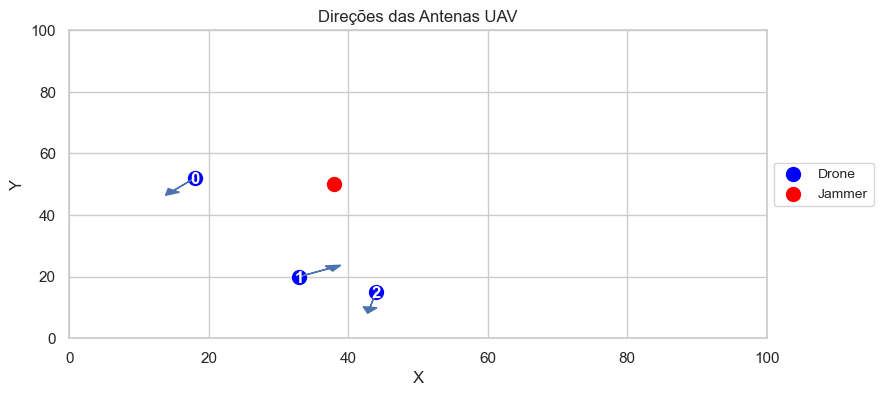

In [22]:
env = UAVCommunicationEnv()

results = []

for _ in range(100):
    state, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Escolha uma ação aleatoriamente
        state, reward, done, info = env.step(action)
        
        # Coletar os resultados
        result = {
            'Direcoes': state.tolist(),
            'Recompensa': reward,
            'Capacidade_Media_Kbps': info['Capacidade média [Kbps]'],
            'Capacidade_Minima_Kbps': info['Capacidade mínima [Kbps]'],
            
        }
        results.append(result)
        done = True  # Executa apenas um passo por episódio

# Salvar os resultados em um arquivo CSV
df = pd.DataFrame(results)
df.to_csv('resultados_uav.csv', index=False)

print("Resultados salvos em 'resultados_uav.csv'.")
    
env.render()
    

ALGORITMO GENETICO PARA TESTE

In [28]:
import random

# Classe do Algoritmo Genético
class GeneticAlgorithm:
    def __init__(self, env, population_size=250, generations=30, mutation_rate=0.15, crossover_rate=0.85):
        self.env = env  # O ambiente do UAV
        self.population_size = population_size  # Tamanho da população
        self.generations = generations  # Número de gerações
        self.mutation_rate = mutation_rate  # Taxa de mutação
        self.crossover_rate = crossover_rate  # Taxa de cruzamento
        
        # Criação de população inicial com valores aleatórios
        self.population = [self.random_chromosome() for _ in range(population_size)]
        
        # Verificar tamanho da população
        assert len(self.population) == self.population_size, "Tamanho da população incorreto"
        for chrom in self.population:
            assert len(chrom) == self.env.num_uavs, "Número de genes no cromossomo está errado"


    # Cria um cromossomo aleatório (direções das antenas para cada drone)
    def random_chromosome(self):
        return np.random.uniform(0, 360, size=self.env.num_uavs)

    # Avalia a aptidão de um cromossomo
    def evaluate_fitness(self, chromosome):
        obs, _ = self.env.reset()
        action = np.array(chromosome)
        try:
            obs, reward, done, info = self.env.step(action)
            return (reward, info)  # Certifique-se de retornar uma tupla
        except Exception as e:
            print(f"Erro: {e}")
            return (0, {})

    # Seleção por torneio
    def select(self):
        tournament_size = 5
        selected = []
        fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
        for _ in range(self.population_size):
            contenders = random.sample(list(enumerate(fitness_scores)), tournament_size)
            # Acessa o valor de fitness para comparação, que é o primeiro elemento da tupla
            winner_index = max(contenders, key=lambda item: item[1][0])[0]  # Ajuste aqui
            selected.append(self.population[winner_index])
        return selected

    # Cruzamento (crossover) entre dois pais
    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            # Ponto de cruzamento
            point = random.randint(1, self.env.num_uavs - 1)
            # Mistura os genes dos pais para criar filhos
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        else:
            return parent1, parent2

    # Aplica mutação a um cromossomo
    def mutate(self, chromosome):
        for i in range(len(chromosome)):
            if random.random() < self.mutation_rate:
                chromosome[i] = random.uniform(0, 360)
        return chromosome

    # Executa o algoritmo genético
    def run(self):
        best_info = None
        for generation in range(self.generations):
            new_population = []
            parents = self.select()  # Seleciona os melhores pais
            
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(parents, 2)
                child1, child2 = self.crossover(parent1, parent2)
                new_population.extend([self.mutate(child1), self.mutate(child2)])  # Adiciona filhos
            
            self.population = new_population[:self.population_size]  # Atualiza a população
            # Calcula a aptidão de todos os cromossomos na população
            fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
            best_fitness, best_info = max(fitness_scores, key=lambda x: x[0])
            
            print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")
        
        # Retorna a melhor solução encontrada
        best_solution_index = max(range(len(self.population)), key=lambda i: fitness_scores[i][0])
        best_solution = self.population[best_solution_index]
        return best_solution, best_info
    
    def reset(self):
        self.direcoes_antena = np.random.uniform(0, 360, size=self.num_uavs)
        assert len(self.direcoes_antena) == self.num_uavs, "Direções das antenas estão incorretas"
        obs = np.array(self.direcoes_antena)
        return obs, {}

Generation 0: Best Fitness = 0.14
Generation 1: Best Fitness = 0.13
Generation 2: Best Fitness = 0.13
Generation 3: Best Fitness = 0.13
Generation 4: Best Fitness = 0.13
Generation 5: Best Fitness = 0.13
Generation 6: Best Fitness = 0.14
Generation 7: Best Fitness = 0.14
Generation 8: Best Fitness = 0.14
Generation 9: Best Fitness = 0.14
Generation 10: Best Fitness = 0.14
Generation 11: Best Fitness = 0.14
Generation 12: Best Fitness = 0.14
Generation 13: Best Fitness = 0.14
Generation 14: Best Fitness = 0.14
Generation 15: Best Fitness = 0.14
Generation 16: Best Fitness = 0.14
Generation 17: Best Fitness = 0.14
Generation 18: Best Fitness = 0.14
Generation 19: Best Fitness = 0.14
Generation 20: Best Fitness = 0.14
Generation 21: Best Fitness = 0.14
Generation 22: Best Fitness = 0.14
Generation 23: Best Fitness = 0.14
Generation 24: Best Fitness = 0.14
Generation 25: Best Fitness = 0.14
Generation 26: Best Fitness = 0.14
Generation 27: Best Fitness = 0.14
Generation 28: Best Fitness = 

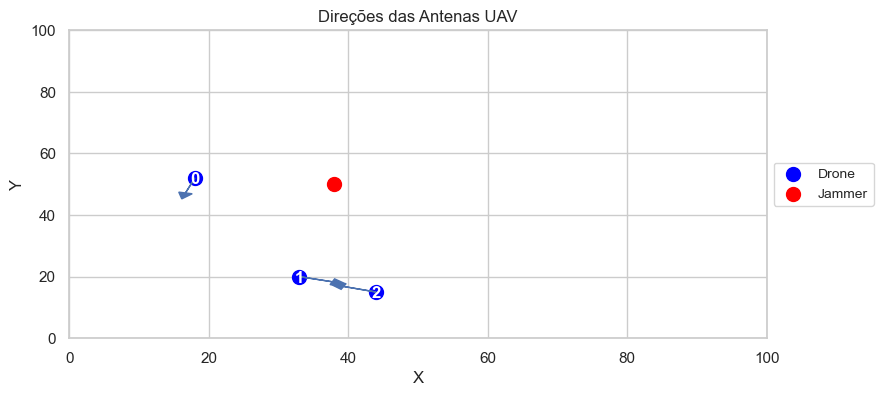

Direções das Antenas: [255.69074057 340.57033893 158.71166439]

Recompensa: 0.13540405713466344

Capacidade Média [Kbps]: 6558.9

Capacidade Minima [Kbps]: 3.1550559055373792

Matriz de Capacidades [Kbps]: 	0.00 18.35 3.15
	6.74 0.00 473.50
	95.43 38756.23 0.00


In [30]:
# Criação do ambiente
env = UAVCommunicationEnv()

# Criação do algoritmo genético
ga = GeneticAlgorithm(env)

# Executar o algoritmo genético
best_solution, best_info = ga.run()

# Renderizar a melhor solução
env.ultima_acao = best_solution
env.render()

print("Direções das Antenas:", best_solution)

if 'Recompensa' in best_info:
    print("\nRecompensa:", best_info['Recompensa'])
if 'Capacidade média [Kbps]' in best_info:
    print("\nCapacidade Média [Kbps]:", best_info['Capacidade média [Kbps]'])
if 'Capacidade média [Kbps]' in info:
    print("\nCapacidade Minima [Kbps]:", best_info['Capacidade mínima [Kbps]'])
# if 'Capacidades_por_link [Kbps]' in info:
#     print("\nCapacidade por Link [Kbps]:", best_info['Capacidades_por_link [Kbps]'])
if 'Matriz de Capacidades [Kbps]' in best_info:
    print("\nMatriz de Capacidades [Kbps]:", '\n'.join(['\t' + ' '.join(f"{item:.2f}" for item in row) for row in best_info['Matriz de Capacidades [Kbps]']]))
    capacidade_matriz = best_info['Matriz de Capacidades [Kbps]']
else:
    print("Chave 'Matriz de Capacidades [Kbps]' não encontrada em info.")


